In [4]:
if (!require(rgdal)) {
    install.packages("rgdal")
    library(rgdal)
}

if (!require(geojsonio)) {
    install.packages("geojsonio")
    library(geojsonio)
}

if (!require(dismo)) {
    install.packages("dismo")
    library(dismo)
}

if (!require(deldir)) {
    install.packages("deldir")
    library(deldir)
}

if (!require(sp)) {
    install.packages("sp")
    library(sp)
}

if (!require(gstat)) {
    install.packages("gstat")
    library(gstat)
}


if (!require("rspatial")) {
    devtools::install_github('rspatial/rspatial')
}

In [5]:
file = geojson_read("meeting-test/data_2020-03-02T22-00-00.geojson", TRUE)

coordinates.raw <- file$features$geometry$coordinates
coordinates.epsg4326 <- data.frame(matrix(unlist(coordinates.raw), nrow=length(coordinates.raw), byrow=T))

colnames(coordinates.epsg4326)[colnames(coordinates.epsg4326) == 'X1'] <- 'x'
colnames(coordinates.epsg4326)[colnames(coordinates.epsg4326) == 'X2'] <- 'y'

values <- file$features$properties$value

# https://epsg.io/3068
crs.external <- CRS("+init=epsg:4326")
crs.internal <- CRS("+init=epsg:3068")

In [6]:
coordinates(coordinates.epsg4326) <- c("x", "y")
proj4string(coordinates.epsg4326) <- crs.external

In [7]:
coordinates.epsg3068 <- spTransform(coordinates.epsg4326, crs.internal)

In [8]:
coordinates.epsg3068$value <- values

In [9]:
xmin <- min(coordinates.epsg3068$x)
ymin <- min(coordinates.epsg3068$y)
xmax <- max(coordinates.epsg3068$x)
ymax <- max(coordinates.epsg3068$y)

bbox <- as(raster::extent(xmin, xmax, ymin, ymax), "SpatialPolygons")
proj4string(bbox) <- crs.internal
# plot(bbox)

In [10]:
zones <- c(0,20,40,100,200,400)

In [11]:
RMSE <- function(observed, predicted) {
  sqrt(mean((predicted - observed)^2, na.rm=TRUE))
}

In [12]:
null <- RMSE(mean(coordinates.epsg3068$value), coordinates.epsg3068$value)
null

[1] 9.334609

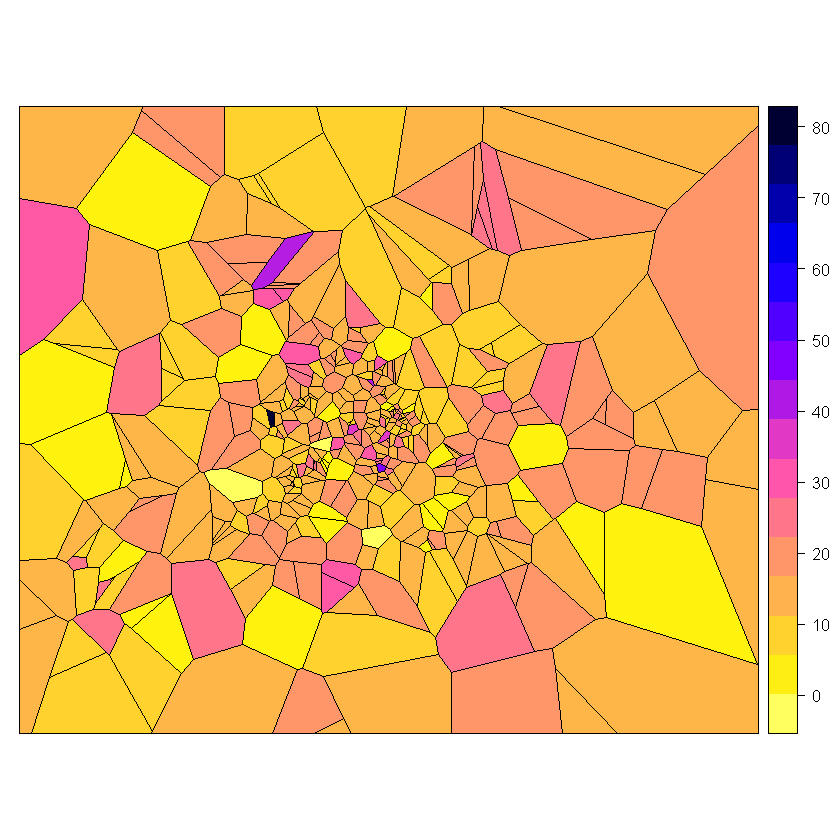

In [37]:
# Nearest Neighbor

v <- voronoi(coordinates.epsg3068)

# plot(v)

v <- intersect(v, bbox)
spplot(v, 'value', col.regions=rev(get_col_regions()))

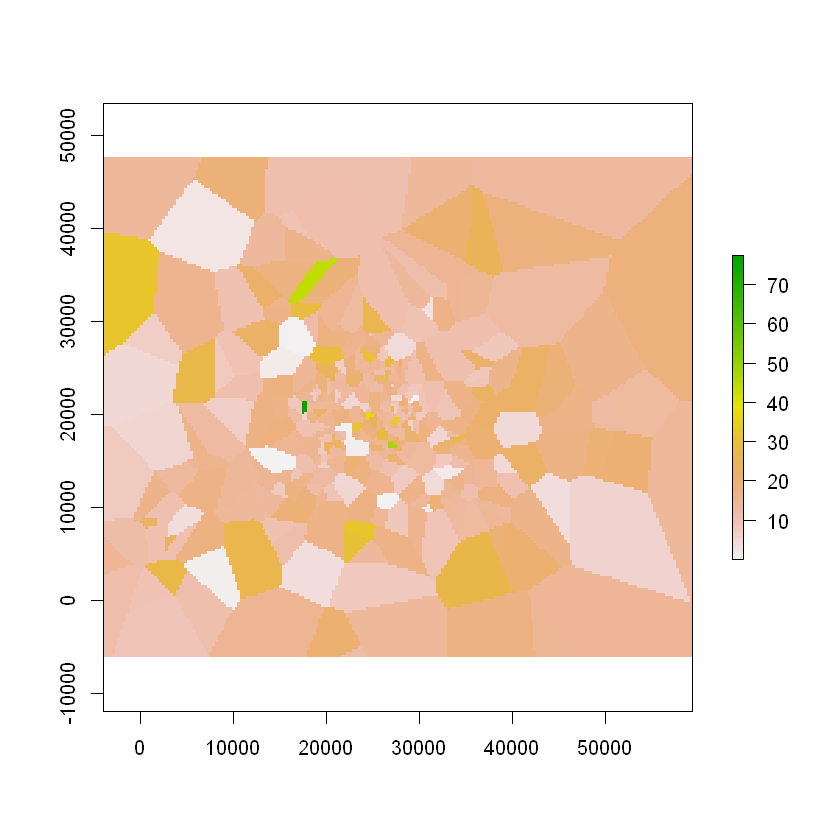

In [38]:
raster <- raster(bbox, res=300)
vr <- rasterize(v, raster, 'value')
plot(vr)

In [39]:
# Nearest Neighbor Cross Validation

#set.seed(5132015)
kf <- kfold(nrow(coordinates.epsg3068))
rmse <- rep(NA, 5)
for (k in 1:5) {
  test <- coordinates.epsg3068[kf == k, ]
  train <- coordinates.epsg3068[kf != k, ]
  v <- voronoi(train)
  p <- extract(v, test)
  rmse[k] <- RMSE(test$value, p$value)
}
rmse
## [1] 199.0686 187.8069 166.9153 191.0938 238.9696
mean(rmse)
## [1] 196.7708
1 - (mean(rmse) / null)
## [1] 0.5479875

[1] 16.388195  6.748899 10.428936 14.586806  7.593585

[1] 11.14928

[1] -0.1944029

[inverse distance weighted interpolation]


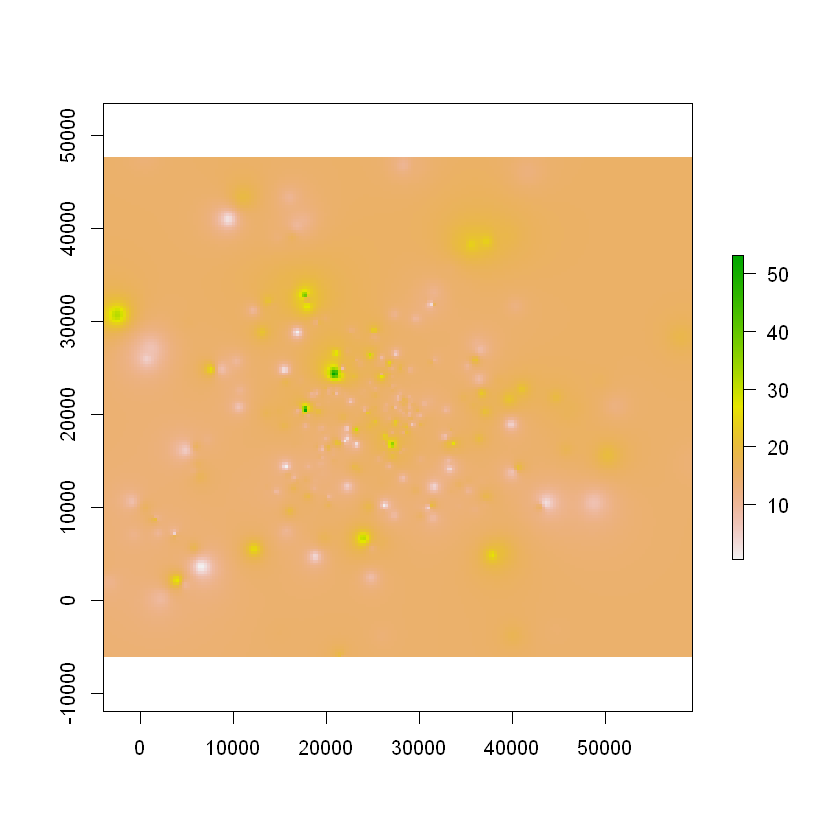

In [40]:
# Inverse Distance Weighting

gs <- gstat(formula=value~1, locations=coordinates.epsg3068)
idw <- interpolate(raster, gs)
## [inverse distance weighted interpolation]
idwr <- mask(idw, vr)
plot(idwr)

In [41]:
# Inverse Distance Weighting Cross Validation

rmse <- rep(NA, 5)
for (k in 1:5) {
  test <- coordinates.epsg3068[kf == k, ]
  train <- coordinates.epsg3068[kf != k, ]
  gs <- gstat(formula=value~1, locations=train)
  p <- predict(gs, test)
  rmse[k] <- RMSE(test$value, p$var1.pred)
}
## [inverse distance weighted interpolation]
## [inverse distance weighted interpolation]
## [inverse distance weighted interpolation]
## [inverse distance weighted interpolation]
## [inverse distance weighted interpolation]
rmse
## [1] 215.3319 211.9383 190.0231 211.8308 230.1893
mean(rmse)
## [1] 211.8627
1 - (mean(rmse) / null)
## [1] 0.5133192

[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]


[1] 15.716165  5.784657 11.897765 14.081822  6.236426

[1] 10.74337

[1] -0.1509177

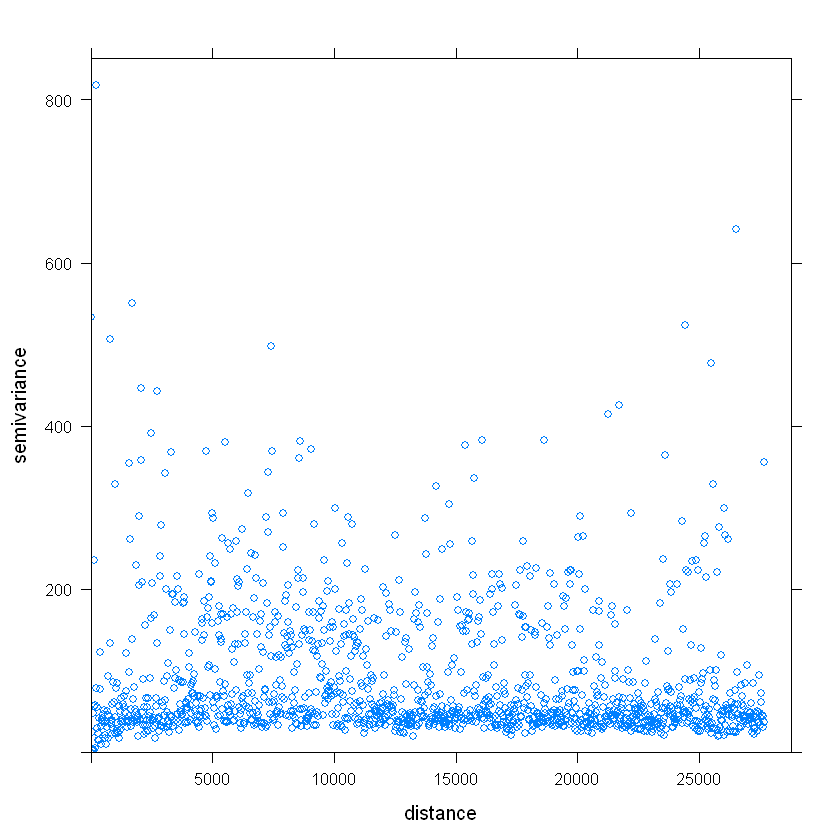

In [57]:
gs <- gstat(formula=value~1, locations=coordinates.epsg3068)
vario <- variogram(gs, width=20)
plot(vario)

Warning message in fit.variogram(vario, vgm(100, "Gau", 1000, 10)):
"No convergence after 200 iterations: try different initial values?"


,model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Nug,43.19280,0.000,0.0,0,0,0,1,1
2,Gau,88.79679,5146.345,0.5,0,0,0,1,1


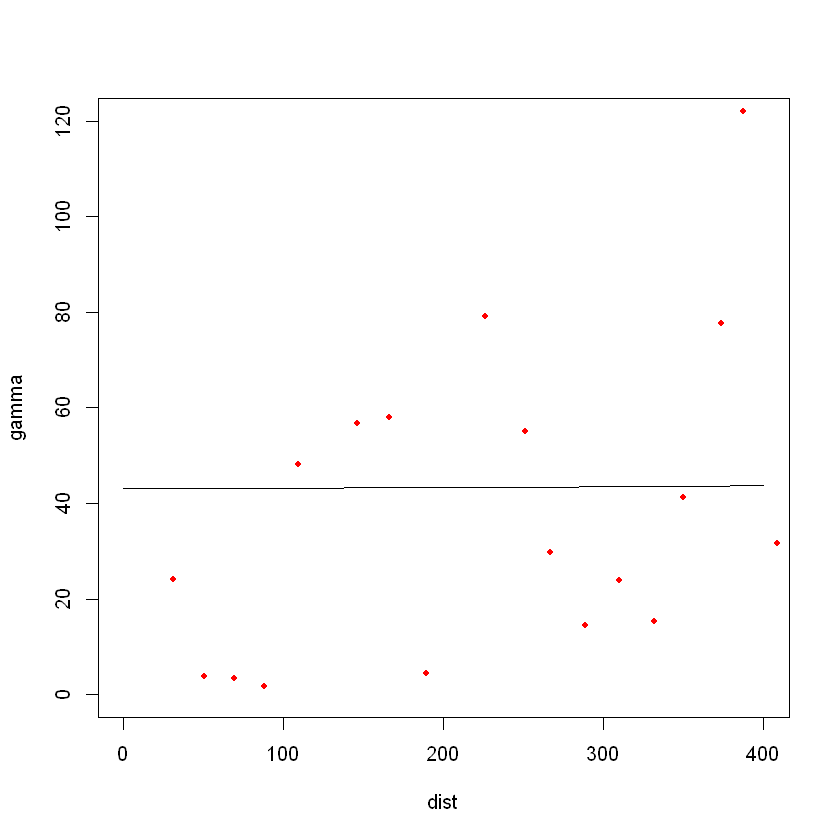

In [55]:
fve <- fit.variogram(vario, vgm(100, "Gau", 1000, 10))
fve
##   model    psill    range
## 1   Nug 21.96600  0.00000
## 2   Exp 85.52957 72.31404
plot(variogramLine(fve, 400), type='l', ylim=c(0,120))
points(vario[,2:3], pch=20, col='red')